## retrieve data from material project

In [1]:
from mp_api.client import MPRester
key="Z7NcMZxFm5LyvsQZk9k7sD8ZgMdQZstr"

with MPRester(key) as mpr:
    data=mpr.materials.summary.search(formula='ABC3',fields=["density","structure","material_id","nelements","formula_pretty","formula_anonymous","theoretical","is_stable", "volume", "elements","band_gap","formation_energy"])
    

C:\Users\YujuL\anaconda3\envs\Group\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving SummaryDoc documents: 100%|██████████| 4555/4555 [00:07<00:00, 588.48it/s]


## Feature Engineering

In [2]:
from matminer.featurizers.bandstructure import BranchPointEnergy
from matminer.featurizers.bandstructure import BandFeaturizer
from matminer.featurizers.structure import XRDPowderPattern
from matminer.featurizers.conversions import StrToComposition

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

In [3]:
mean_atomic_numbers=[]
max_atomic_numbers=[]
min_atomic_numbers=[]
std_atomic_numbers=[]
# position of the atomic
a_parameters=[]
b_parameters=[]
c_parameters=[]
# angles between the bond
alpha_parameters=[]
beta_parameters=[]
gamma_parameters=[]
# distance betweeen atomics
mean_distance_matrix=[]
max_distance_matrix=[]
min_distance_matrix=[]
std_distance_matrix=[]
density=[]
volume=[]

bandgap=[]

In [4]:
for sam in data:
    sample=sam.structure
    if sam.band_gap>1:
        mean_atomic_numbers+=[np.mean(sample.atomic_numbers)]
        max_atomic_numbers+=[np.max(sample.atomic_numbers)]
        min_atomic_numbers+=[np.min(sample.atomic_numbers)]
        std_atomic_numbers+=[np.std(sample.atomic_numbers)]
        a_parameters+=[sample.lattice.abc[0]]
        b_parameters+=[sample.lattice.abc[1]]
        c_parameters+=[sample.lattice.abc[2]]
        alpha_parameters+=[sample.lattice.angles[0]]
        beta_parameters+=[sample.lattice.angles[1]]
        gamma_parameters+=[sample.lattice.angles[2]]
        mean_distance_matrix+=[np.mean(sample.distance_matrix)] 
        max_distance_matrix+=[np.max(sample.distance_matrix)]
        min_distance_matrix+=[np.min(sample.distance_matrix)]
        std_distance_matrix+=[np.std(sample.distance_matrix)]

        bandgap+=[sam.band_gap]
        

In [5]:
dataset_df= pd.DataFrame({"mean_atomic_numbers":mean_atomic_numbers, # 
                          "max_atomic_numbers":max_atomic_numbers,
                         "min_atomic_numbers":min_atomic_numbers,
                         "std_atomic_numbers":std_atomic_numbers,
                         "a_parameters":a_parameters,
                         "b_parameters":b_parameters,
                         "c_parameters":c_parameters,
                         "alpha_parameters":alpha_parameters,
                         "beta_parameters":beta_parameters,
                         "gamma_parameters":gamma_parameters,
                         "max_distance_matrix":max_distance_matrix,
                         "min_distance_matrix":min_distance_matrix,
                         "std_distance_matrix":std_distance_matrix                          
                         })

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(dataset_df,bandgap,test_size=0.2,random_state=42)

In [7]:
models=[]
accuracy=[]

### Random Forest

In [9]:
from sklearn.model_selection import RandomizedSearchCV

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(max_features=1.0)

grid_param={'n_estimators':[int(x) for x in np.linspace(start=100,stop=1000,num=3)],
           'max_features':['auto','sqrt'],
           'max_depth':[int(x) for x in np.linspace(start=10,stop=100,num=3)],
            'min_samples_split':[2,5],
            'min_samples_leaf':[1,2],
            'bootstrap':[True]
           }

rand_ser = RandomizedSearchCV(estimator=rf,param_distributions=grid_param,n_iter=10,)
rand_ser.fit(X_train,y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 55, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 550, 1000]})

In [14]:
print(f'best parameter:{rand_ser.best_params_}')
print(f'best score:{rand_ser.best_score_}')

best parameter:{'n_estimators': 550, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}
best score:0.44262147242288136


In [15]:
rf_model=rand_ser.best_estimator_

In [16]:

y_pred=rf_model.predict(X_test)
testing_accuracy = rf_model.score(X_test, y_test) * 100
models.append('Randomforest')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')


 Accuracy on test data: 52.9 %


In [17]:
MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:0.9243824435035173
R2:0.5286535513253928


In [18]:
regr= RandomForestRegressor(n_estimators=1000,max_depth=1000,random_state=42)
regr.fit(X_train,y_train)
y_pred=regr.predict(X_test)
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))


0.8525920467713654
0.529696577262935


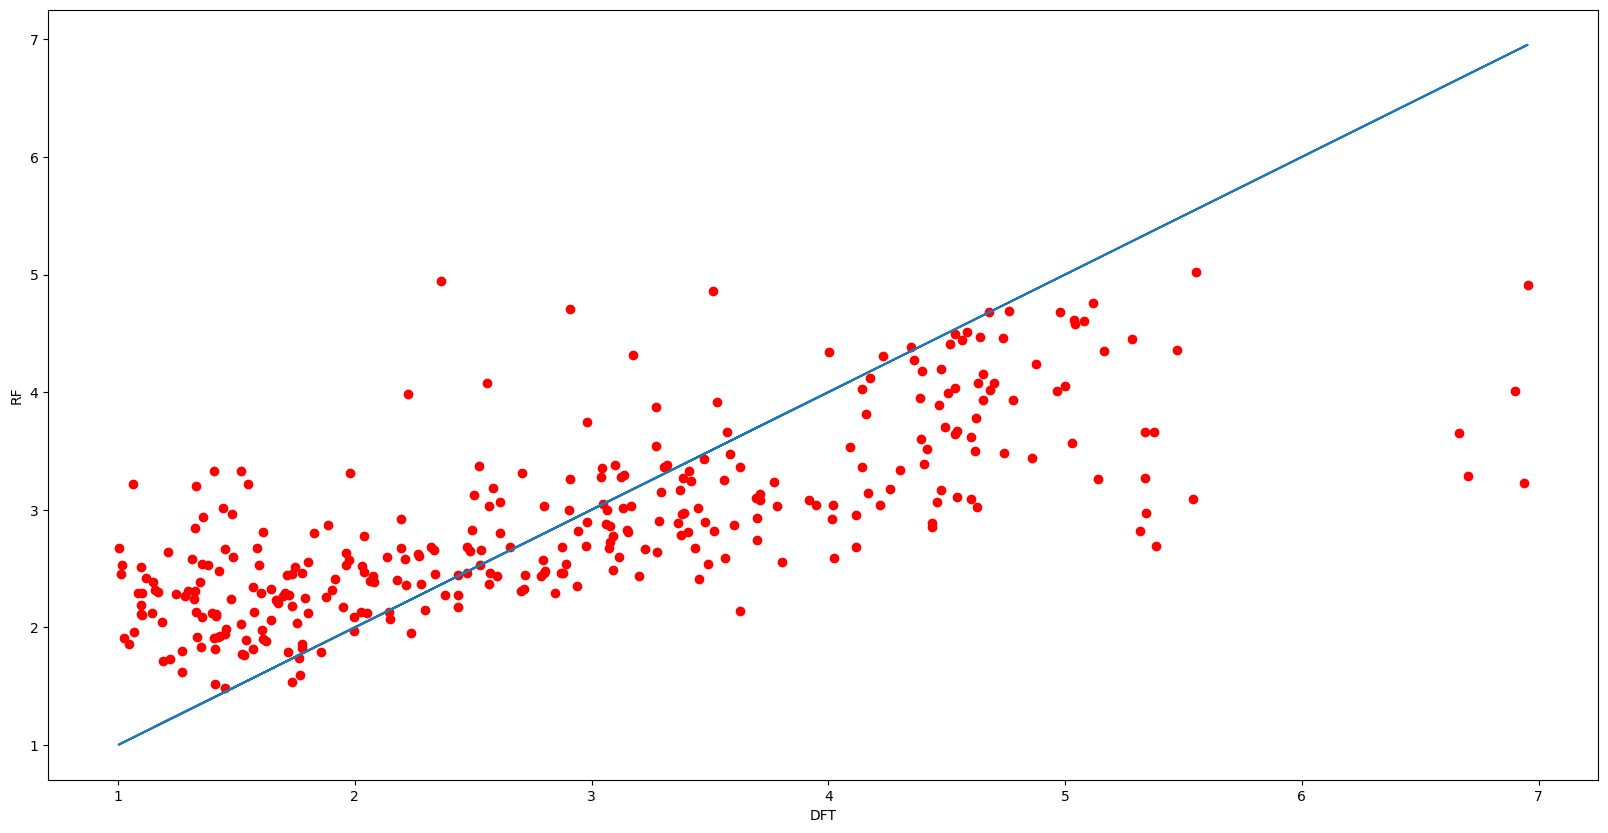

In [19]:

xPlot=y_test
yPlot=y_pred
plt.figure(figsize=(20,10))
plt.plot(xPlot,yPlot,'ro')
plt.plot(xPlot,xPlot)
plt.xlabel('DFT')
plt.ylabel('RF')
plt.savefig('RF-Correlation_Test',bbox_inches='tight')


## XGBoost

In [20]:
from xgboost import XGBRegressor

In [21]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train,y_train)
y_pred=xgb_model.predict(X_test)
testing_accuracy = xgb_model.score(X_test, y_test) * 100
models.append('XGBoost')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')
print(f'mse: {mean_squared_error(y_test,y_pred)}%')
print(f'r2: {r2_score(y_test,y_pred)}%')

 Accuracy on test data: 56.2 %
mse: 0.7934430973427661%
r2: 0.5623240847243451%


In [22]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBoostRegressor model
xgb = XGBRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1)


In [23]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters found:", best_params)
print("Best score (r2) found:",best_score)

Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Best score (r2) found: 0.4830512742687228


In [24]:
y_pred=grid_search.predict(X_test)
testing_accuracy = grid_search.score(X_test, y_test) * 100
models.append('XGBoost')
accuracy.append(testing_accuracy)
print(f' Accuracy on test data: {testing_accuracy:.1f} %')
print(f'r2: {r2_score(y_test,y_pred)}%')

 Accuracy on test data: 58.4 %
r2: 0.5839375399599764%


In [25]:
MSE=mean_squared_error(y_test,y_pred)
RMSE=np.sqrt(MSE)
R2=r2_score(y_test,y_pred)
print('RMSE:'+ str(RMSE))
print('R2:'+str(R2))

RMSE:0.8684820267176455
R2:0.5839375399599764


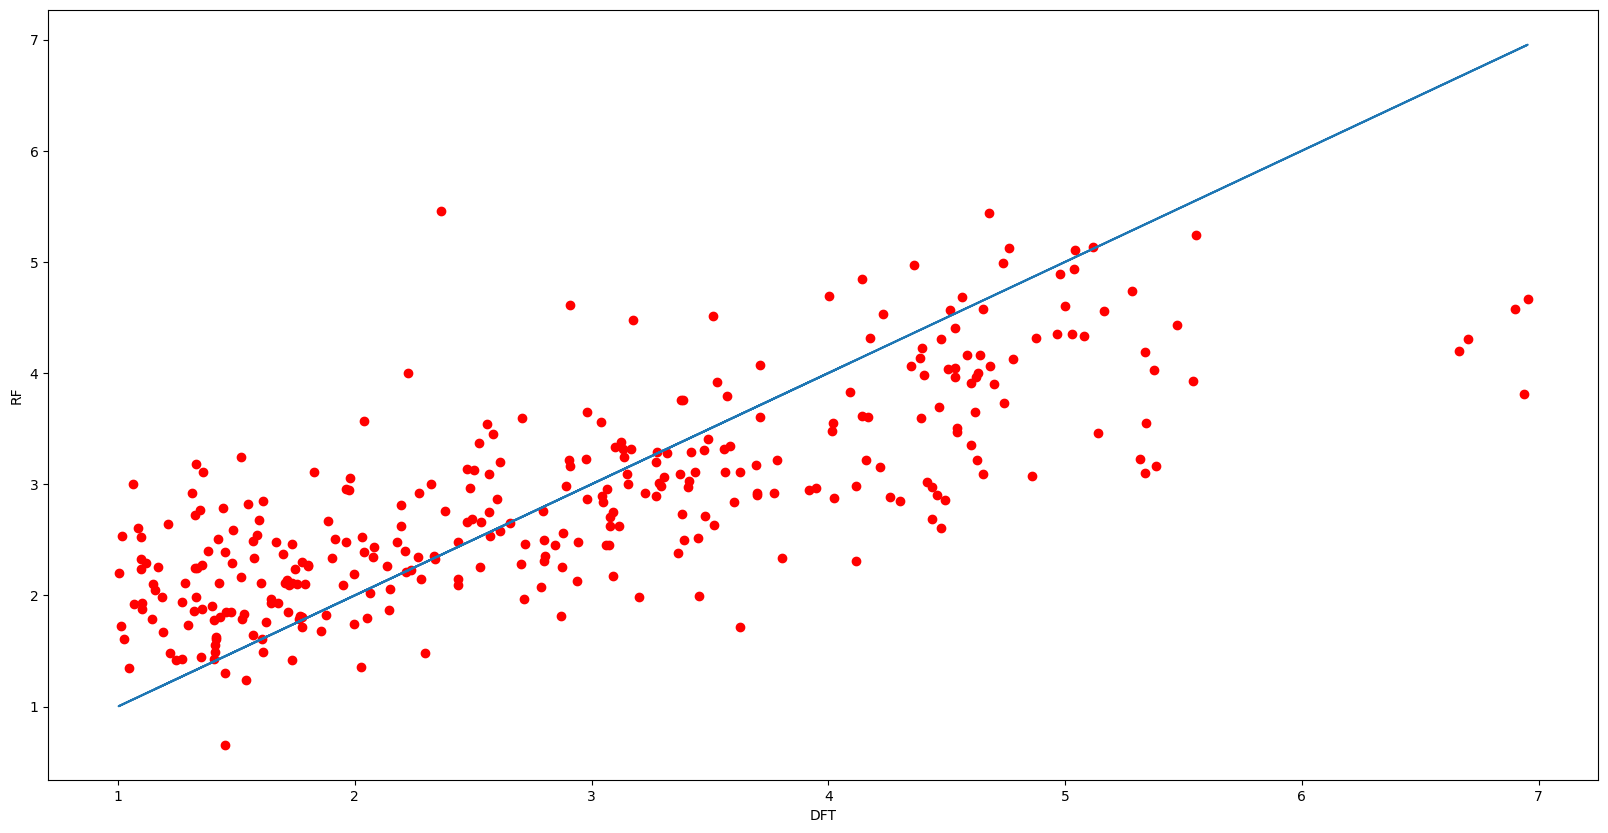

In [26]:
import matplotlib.pyplot as plt
xPlot=y_test
yPlot=y_pred
plt.figure(figsize=(20,10))
plt.plot(xPlot,yPlot,'ro')
plt.plot(xPlot,xPlot)
plt.xlabel('DFT')
plt.ylabel('RF')
plt.savefig('RF-Correlation_Test',bbox_inches='tight')


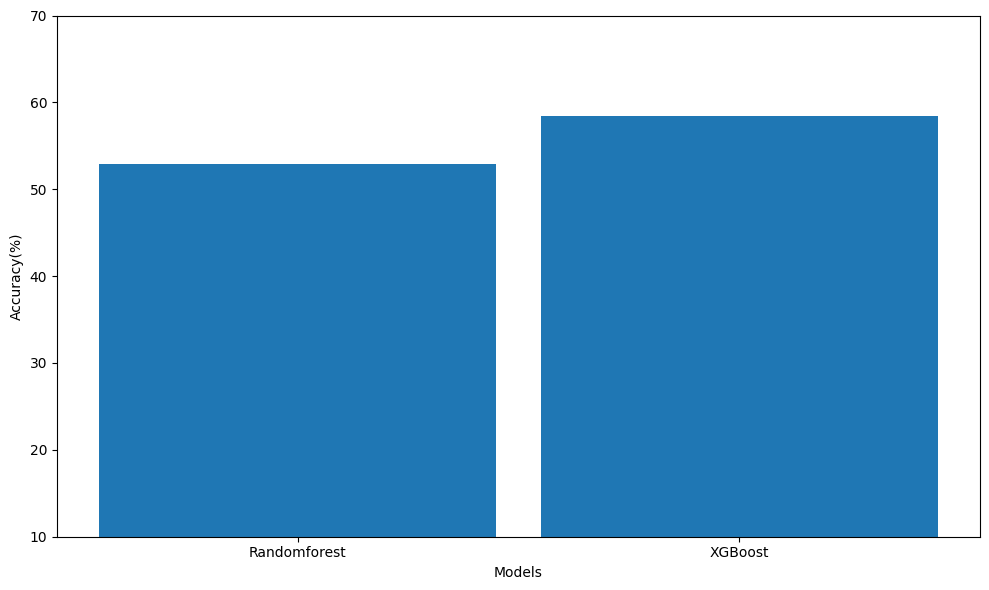

In [27]:
plt.figure(figsize=(10, 6))
plt.bar(models,accuracy,width=0.9)
plt.xlabel('Models')
plt.ylabel('Accuracy(%)')
plt.ylim(10, 70)
plt.tight_layout()
plt.show()